# Importing Lib's

In [42]:
!pip install rasterio

In [43]:
!pip install sentinelhub

In [44]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, CRS, MimeType
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, bbox_to_dimensions, DataCollection
import rasterio
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model  # For loading pre-trained models
from shapely.geometry import Point
from sklearn.metrics import roc_curve, auc, precision_score, confusion_matrix

# AIS Data

In [45]:
# Loading AIS Data
ships_data = pd.read_csv('/content/drive/MyDrive/Oil Spill/ships.csv')


In [46]:
ships_data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,368140160,2022-01-01T00:00:00,30.33475,-87.14429,0.0,312.0,87.0,TWISTED ANGEL,IMO0000000,WDL5339,36.0,NaN,12.0,7.0,NaN,NaN,B
1,368140160,2022-01-01T00:03:02,30.33475,-87.14429,0.0,312.0,87.0,TWISTED ANGEL,IMO0000000,WDL5339,36.0,NaN,12.0,7.0,NaN,NaN,B
2,368140160,2022-01-01T00:06:03,30.33475,-87.14429,0.0,312.0,87.0,TWISTED ANGEL,IMO0000000,WDL5339,36.0,NaN,12.0,7.0,NaN,NaN,B
3,368140160,2022-01-01T00:09:01,30.33475,-87.14429,0.0,312.0,87.0,TWISTED ANGEL,IMO0000000,WDL5339,36.0,NaN,12.0,7.0,NaN,NaN,B
4,368140160,2022-01-01T00:15:02,30.33475,-87.14429,0.0,312.0,88.0,TWISTED ANGEL,IMO0000000,WDL5339,36.0,NaN,12.0,7.0,NaN,NaN,B


In [47]:
ships_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4083 entries, 0 to 4082
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MMSI              4083 non-null   int64  
 1   BaseDateTime      4083 non-null   object 
 2   LAT               4083 non-null   float64
 3   LON               4083 non-null   float64
 4   SOG               4083 non-null   float64
 5   COG               4083 non-null   float64
 6   Heading           4083 non-null   float64
 7   VesselName        4083 non-null   object 
 8   IMO               1979 non-null   object 
 9   CallSign          4083 non-null   object 
 10  VesselType        4083 non-null   float64
 11  Status            3387 non-null   float64
 12  Length            4083 non-null   float64
 13  Width             4083 non-null   float64
 14  Draft             2495 non-null   float64
 15  Cargo             3387 non-null   float64
 16  TransceiverClass  4083 non-null   object 


In [48]:
ships_data.describe()

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,Status,Length,Width,Draft,Cargo
count,4.083000e+03,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,3387.000000,4083.000000,4083.000000,2495.000000,3387.000000
mean,3.514796e+08,35.134837,-89.005421,1.736321,266.549057,244.557188,39.570169,4.670505,23.325006,8.751163,4.120962,71.940360
std,2.401983e+07,7.792038,3.824902,3.042820,79.274964,186.289391,11.467790,5.621984,7.877176,1.533489,1.149864,20.277752
min,3.160041e+08,29.309160,-94.892180,0.000000,0.000000,0.000000,31.000000,0.000000,12.000000,5.000000,3.000000,50.000000
25%,3.160060e+08,29.942880,-90.398250,0.000000,277.300000,86.000000,31.000000,0.000000,18.000000,7.000000,3.000000,57.000000
50%,3.669418e+08,29.967400,-90.089180,0.000000,295.300000,285.000000,31.000000,0.000000,23.000000,10.000000,3.000000,57.000000
75%,3.680841e+08,46.501820,-84.925225,2.200000,311.000000,351.500000,57.000000,12.000000,34.000000,10.000000,5.300000,99.000000
max,3.681402e+08,47.254340,-84.356740,8.900000,359.500000,511.000000,57.000000,12.000000,34.000000,10.000000,5.300000,99.000000


In [49]:
ships_data.shape

(4083, 17)

In [50]:
ships_data.isnull().sum()

,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
VesselName,0
IMO,2104
CallSign,0


In [51]:
# Desired column Selection
columns_to_keep = ["LAT", "LON", "SOG", "COG", "BaseDateTime", "VesselName"]
ships_data = ships_data[columns_to_keep]

In [52]:
# Selecting Features for clustering
features = ['LAT', 'LON', 'SOG', 'COG']
data = ships_data[features]

In [53]:
# Normalizing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [54]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(scaled_data)

In [55]:
# cluster labels to original dataset
ships_data['Cluster'] = labels

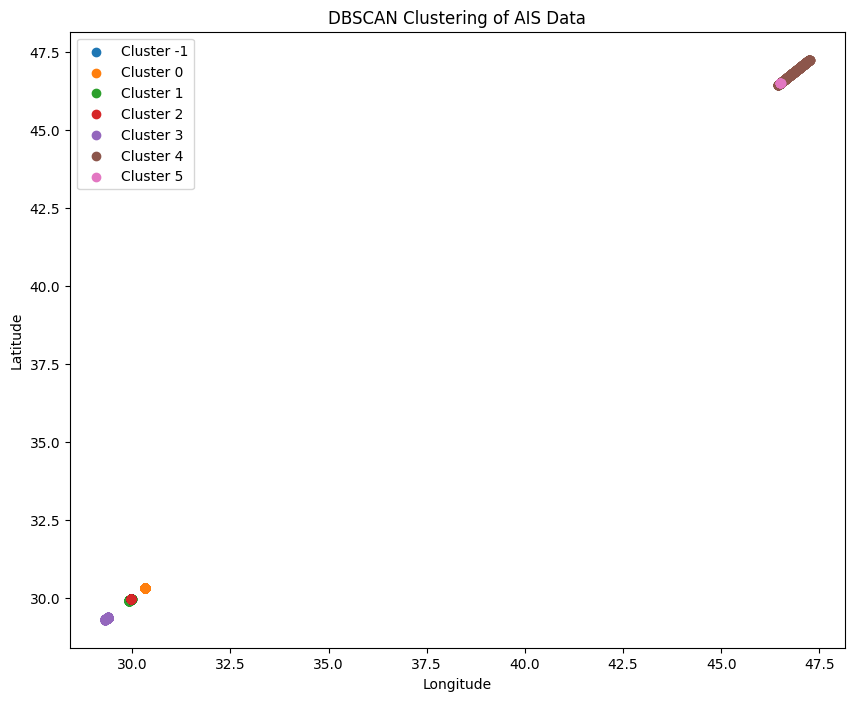

In [56]:
# Visualization of clusters
plt.figure(figsize=(10, 8))
for cluster_label in np.unique(labels):
    cluster_data = ships_data[ships_data['Cluster'] == cluster_label]
    plt.scatter(cluster_data['LAT'], cluster_data['LAT'], label=f'Cluster {cluster_label}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of AIS Data')
plt.legend()
plt.show()

In [57]:
# Identification of anomalies
anomalies = ships_data[ships_data['Cluster'] == -1]
print("Anomalies detected:")
print(anomalies)

Anomalies detected:
           LAT       LON  SOG    COG         BaseDateTime       VesselName  \
432   29.92789 -90.13716  6.1    1.9  2022-01-01T01:43:40  LARRY B WHIPPLE   
437   29.92985 -90.13705  6.2    3.6  2022-01-01T01:44:50  LARRY B WHIPPLE   
1344  29.96737 -90.39816  0.3   77.3  2022-01-01T20:34:49  LARRY B WHIPPLE   
1434  29.96727 -90.39819  0.1  112.3  2022-01-01T23:08:20  LARRY B WHIPPLE   
4028  46.50283 -84.37153  5.6   86.1  2022-01-01T00:14:08       ADANAC III   
4029  46.50229 -84.36993  2.2  195.2  2022-01-01T00:15:26       ADANAC III   
4070  46.50139 -84.40117  5.7  111.9  2022-01-01T01:04:48       ADANAC III   
4076  46.51430 -84.37283  3.5   35.4  2022-01-01T01:16:27       ADANAC III   

      Cluster  
432        -1  
437        -1  
1344       -1  
1434       -1  
4028       -1  
4029       -1  
4070       -1  
4076       -1  


In [58]:
# Saving the clustered data and anomalies
ships_data.to_csv('clustered_ais_data.csv', index=False)
anomalies.to_csv('anomalies.csv', index=False)

# Satellite Imagery

In [59]:
file_path = 'anomalies.csv'
anomalies_data = pd.read_csv(file_path)

In [60]:
# Extractraction of latitude and longitude bounds
lat_min = anomalies_data['LAT'].min()
lat_max = anomalies_data['LAT'].max()
lon_min = anomalies_data['LON'].min()
lon_max = anomalies_data['LON'].max()

In [61]:
# Adding Buffer to the bounding box
buffer = 0.01
lat_min -= buffer
lat_max += buffer
lon_min -= buffer
lon_max += buffer

In [62]:
# Setting up SentinelHub Configuration**
config = SHConfig()

In [63]:
# Replacing the values with SentinelHub credentials
config.instance_id = '1b320a47-012c-4c2a-8854-bc1a9618a347'
config.sh_client_id = 'c469a180-34b0-4a19-83c0-9cea17f5b159'
config.sh_client_secret = 'Fc4p6AEpDdFMULvQDJftC35Rr5qYpFMv'

In [64]:
 # Ensuring credentials
if not config.instance_id or not config.sh_client_id or not config.sh_client_secret:
    raise ValueError("SentinelHub credentials are missing. Please set your instance ID, client ID, and client secret.")


In [65]:
# Defining Bounding Box and Resolution
bbox = BBox(bbox=[lon_min, lat_min, lon_max, lat_max], crs=CRS.WGS84)
resolution = 10  # Define spatial resolution in meters
bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

In [66]:
# Adjusting resolution if bbox_size exceeds the limit
max_size = 2500  # Maximum allowed size for width and height
if bbox_size[0] > max_size or bbox_size[1] > max_size:
    scaling_factor = max(bbox_size[0] / max_size, bbox_size[1] / max_size)
    resolution *= scaling_factor  # Increase resolution to reduce size
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)  # Recalculate size
    print(f"Adjusted resolution to {resolution:.2f} meters to fit size limits.")

print("Bounding Box Size:", bbox_size)

Adjusted resolution to 736.45 meters to fit size limits.
Bounding Box Size: (722, 2500)


In [67]:
# Defining Evalscript for Sentinel-1
evalscript = """
// Sentinel-1 custom script to visualize oil spill data
function setup() {
  return {
    input: ["VV", "VH", "dataMask"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [sample.VV, sample.VH, sample.dataMask];
}
"""

In [68]:
# Fetching Satellite Data
request = SentinelHubRequest(
    data_folder='satellite_images',
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1,
            time_interval=('2022-01-01', '2024-12-03')
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=bbox_size,
    config=config
)

response = request.get_data()
print("Satellite data fetched successfully.")


Satellite data fetched successfully.


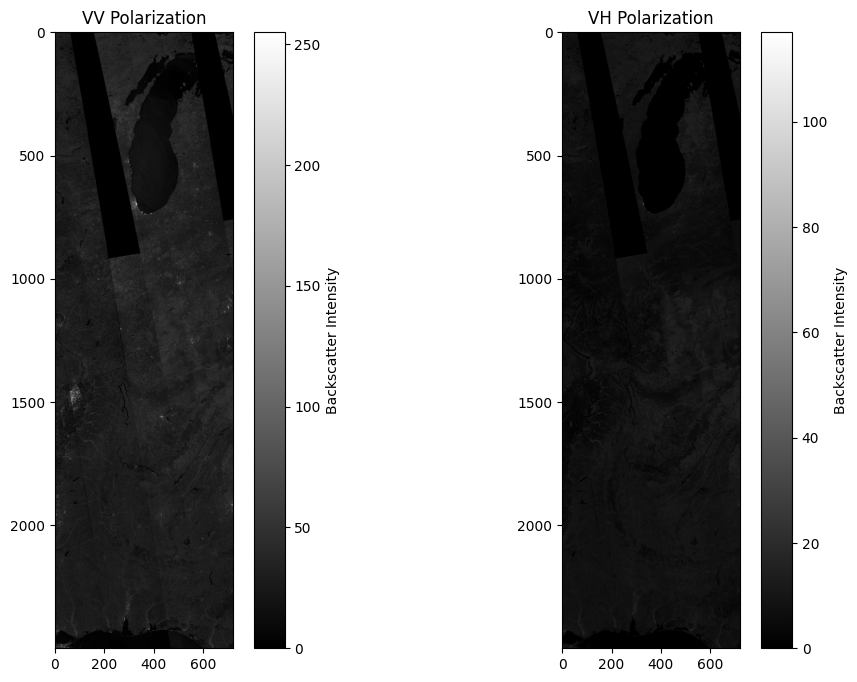

In [69]:
# Visualizing VV and VH Polarizations
vv_image = response[0][:, :, 0]  # VV polarization
vh_image = response[0][:, :, 1]  # VH polarization

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('VV Polarization')
plt.imshow(vv_image, cmap='gray')
plt.colorbar(label='Backscatter Intensity')

plt.subplot(1, 2, 2)
plt.title('VH Polarization')
plt.imshow(vh_image, cmap='gray')
plt.colorbar(label='Backscatter Intensity')
plt.show()


# Overlaying

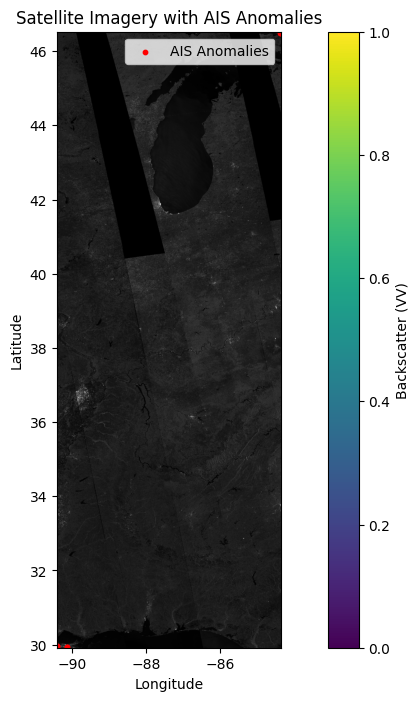

In [70]:
# Overlaying AIS Anomalies on Satellite Imagery
plt.figure(figsize=(12, 8))
plt.imshow(vv_image, cmap='gray', extent=(lon_min, lon_max, lat_min, lat_max))
plt.scatter(anomalies_data['LON'], anomalies_data['LAT'], c='red', s=10, label='AIS Anomalies')
plt.title('Satellite Imagery with AIS Anomalies')
plt.legend()
plt.colorbar(label='Backscatter (VV)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Oil Spill Detection

In [71]:
# Loading Anomalies
anomalies = pd.read_csv('anomalies.csv')
ds = list(zip(anomalies['LON'], anomalies['LAT']))
print("Anomalies loaded:", ds)

Anomalies loaded: [(-90.13716, 29.92789), (-90.13705, 29.92985), (-90.39816, 29.96737), (-90.39819, 29.96727), (-84.37153, 46.50283), (-84.36993, 46.50229), (-84.40117, 46.50139), (-84.37283, 46.5143)]


In [72]:
# Normalizing Sentinel-1 Data
# Normalization of VV and VH images
vv_normalized = (vv_image - np.min(vv_image)) / (np.max(vv_image) - np.min(vv_image))
vh_normalized = (vh_image - np.min(vh_image)) / (np.max(vh_image) - np.min(vh_image))

In [73]:
# Preparing input data for the U-Net model
satellite_data = np.stack([vv_normalized, vh_normalized], axis=-1)  # Shape (H, W, 2)
print(f"Satellite data shape: {satellite_data.shape}")


Satellite data shape: (2500, 722, 2)


In [74]:
# Defining or Loading the U-Net Model
"""input_shape = satellite_data.shape  # Shape (H, W, Channels)

# Example of a placeholder U-Net architecture (modify as needed for a true U-Net)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')  # Output layer for binary segmentation
])
"""

"input_shape = satellite_data.shape  # Shape (H, W, Channels)\n\n# Example of a placeholder U-Net architecture (modify as needed for a true U-Net)\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),\n    tf.keras.layers.MaxPooling2D((2, 2)),\n    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),\n    tf.keras.layers.MaxPooling2D((2, 2)),\n    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),\n    tf.keras.layers.UpSampling2D((2, 2)),\n    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),\n    tf.keras.layers.UpSampling2D((2, 2)),\n    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')  # Output layer for binary segmentation\n])\n"

In [75]:
# Compiling Model
"""model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary segmentation
              metrics=['accuracy'])"""

"model.compile(optimizer='adam',\n              loss='binary_crossentropy',  # Binary segmentation\n              metrics=['accuracy'])"

In [76]:
# Saving the model
#model.save('/content/drive/MyDrive/Oil Spill/oil_spill_detection_model.h5')


In [77]:
# Predicting Using the Model
model = load_model('/content/drive/MyDrive/Oil Spill/oil_spill_detection_model.h5')
segmentation_map = model.predict(np.expand_dims(satellite_data, axis=0))  # Adding batch dimension

# Post-processing the segmentation map
segmentation_map = segmentation_map.squeeze()  # Removing batch dimension
thresholded_map = (segmentation_map > 0.5).astype(np.uint8)  # Applying threshold for binary mask
print("Segmentation map generated.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Segmentation map generated.


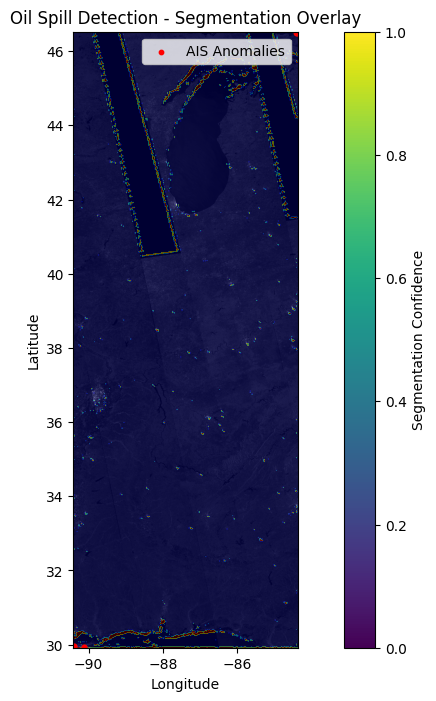

In [78]:
# Visualizing Results
plt.figure(figsize=(12, 8))

# Displaying VV Image as the base
plt.imshow(vv_image, cmap='gray', extent=(lon_min, lon_max, lat_min, lat_max))

# Overlaying Thresholded Segmentation Map
plt.imshow(thresholded_map, alpha=0.4, cmap='jet', extent=(lon_min, lon_max, lat_min, lat_max))

# Adding AIS anomaly points for validation
plt.scatter(anomalies['LON'], anomalies['LAT'], c='red', s=10, label='AIS Anomalies')

plt.title('Oil Spill Detection - Segmentation Overlay')
plt.colorbar(label='Segmentation Confidence')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Validation

In [79]:
# Extracting Data from SentinelHubRequest
# Assuming response contains the Sentinel-1 image data
satellite_data = response[0]  # Sentinel-1 data (H, W, Bands)
vv_band = satellite_data[:, :, 0]  # VV polarization
vh_band = satellite_data[:, :, 1]  # VH polarization
data_mask = satellite_data[:, :, 2]  # Valid data mask (0 or 1)

In [80]:
# Binary mask (oil spill prediction from U-Net model)
binary_mask = thresholded_map  # Output of the U-Net model
image_shape = binary_mask.shape  # Shape of the binary mask (Height, Width)

In [81]:
# Defining Geospatial Extent
# Extracting bounding box coordinates (adjust these based on your BBox object)
sentinel_extent = {
    "min_lon": bbox.min_x,  # Minimum Longitude
    "max_lon": bbox.max_x,  # Maximum Longitude
    "min_lat": bbox.min_y,  # Minimum Latitude
    "max_lat": bbox.max_y   # Maximum Latitude
}

# Example AIS anomalies (replace with your data)
ais_anomalies = ds  # List of (longitude, latitude) tuples

In [82]:
# GPS to Image Pixel Conversion
def gps_to_image_coords(lon, lat, extent, image_shape):
    """
    Convert GPS coordinates (lon, lat) to image pixel coordinates (x, y).
    """
    h, w = image_shape  # Binary mask dimensions (Height, Width)
    x = int((lon - extent["min_lon"]) / (extent["max_lon"] - extent["min_lon"]) * w)
    y = int((extent["max_lat"] - lat) / (extent["max_lat"] - extent["min_lat"]) * h)
    return x, y

# Converting AIS anomalies to pixel coordinates
ais_image_coords = [gps_to_image_coords(lon, lat, sentinel_extent, image_shape) for lon, lat in ais_anomalies]

In [83]:
# Validation of AIS Points
validation_results = []
for coord in ais_image_coords:
    x, y = coord
    if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:  # Ensure point is within image bounds
        is_oil_spill = binary_mask[y, x]  # Check the segmentation mask value at the AIS point
        validation_results.append((coord, bool(is_oil_spill)))
    else:
        validation_results.append((coord, False))  # Mark out-of-bounds points as invalid

In [84]:
# Displaying Validation Results
print("\nValidation Results:")
for idx, (coord, result) in enumerate(validation_results):
    status = "Oil Spill Detected" if result else "No Oil Spill Detected"
    print(f"AIS Point {idx + 1} at {coord}: {status}")



Validation Results:
AIS Point 1 at (32, 2498): Oil Spill Detected
AIS Point 2 at (32, 2498): Oil Spill Detected
AIS Point 3 at (1, 2492): No Oil Spill Detected
AIS Point 4 at (1, 2492): No Oil Spill Detected
AIS Point 5 at (718, 3): No Oil Spill Detected
AIS Point 6 at (718, 3): No Oil Spill Detected
AIS Point 7 at (715, 3): No Oil Spill Detected
AIS Point 8 at (718, 1): No Oil Spill Detected


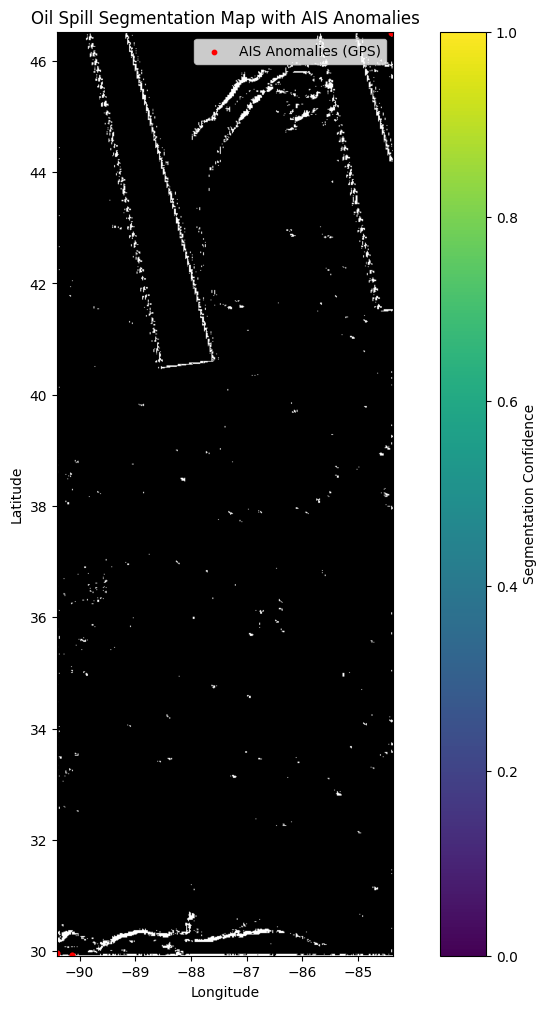

In [85]:
# Visualization
plt.figure(figsize=(12, 12))

# Displaying the binary segmentation mask as the base layer
plt.imshow(
    binary_mask,
    cmap='gray',
    extent=[sentinel_extent["min_lon"], sentinel_extent["max_lon"],
            sentinel_extent["min_lat"], sentinel_extent["max_lat"]]
)

# Overlaying AIS anomaly points
plt.scatter(
    [lon for lon, lat in ais_anomalies],
    [lat for lon, lat in ais_anomalies],
    color='red', label='AIS Anomalies (GPS)', s=10
)

# Customizing visualization
plt.title("Oil Spill Segmentation Map with AIS Anomalies")
plt.colorbar(label="Segmentation Confidence")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


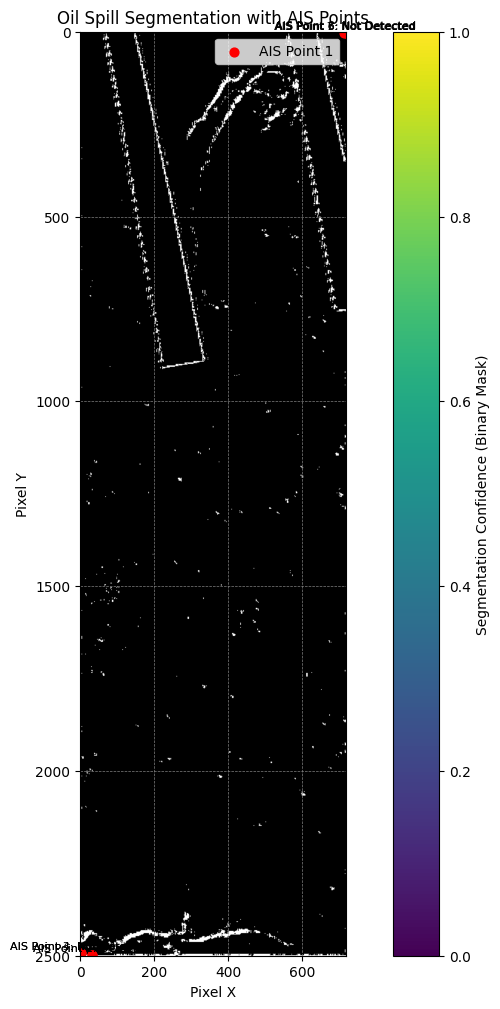

In [87]:
# Visualizing the segmentation map and AIS points with labels
plt.figure(figsize=(12, 12))
plt.imshow(binary_mask, cmap='gray', extent=[0, binary_mask.shape[1], binary_mask.shape[0], 0])  # Flip Y-axis for correct orientation
plt.title("Oil Spill Segmentation with AIS Points")

# Ploting AIS points with labels
for idx, ((x, y), result) in enumerate(validation_results):
    # Ensuring the point is within bounds before plotting
    if 0 <= x < binary_mask.shape[1] and 0 <= y < binary_mask.shape[0]:
        label = f"AIS Point {idx + 1}: {'Detected' if result else 'Not Detected'}"
        plt.text(x, y - 5, label, fontsize=8, color='black', ha='center', va='bottom')  # Adjust label positioning
        plt.scatter(x, y, color='red', label=f'AIS Point {idx + 1}' if idx == 0 else None, s=40)

plt.colorbar(label="Segmentation Confidence (Binary Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.legend(loc='upper right', fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


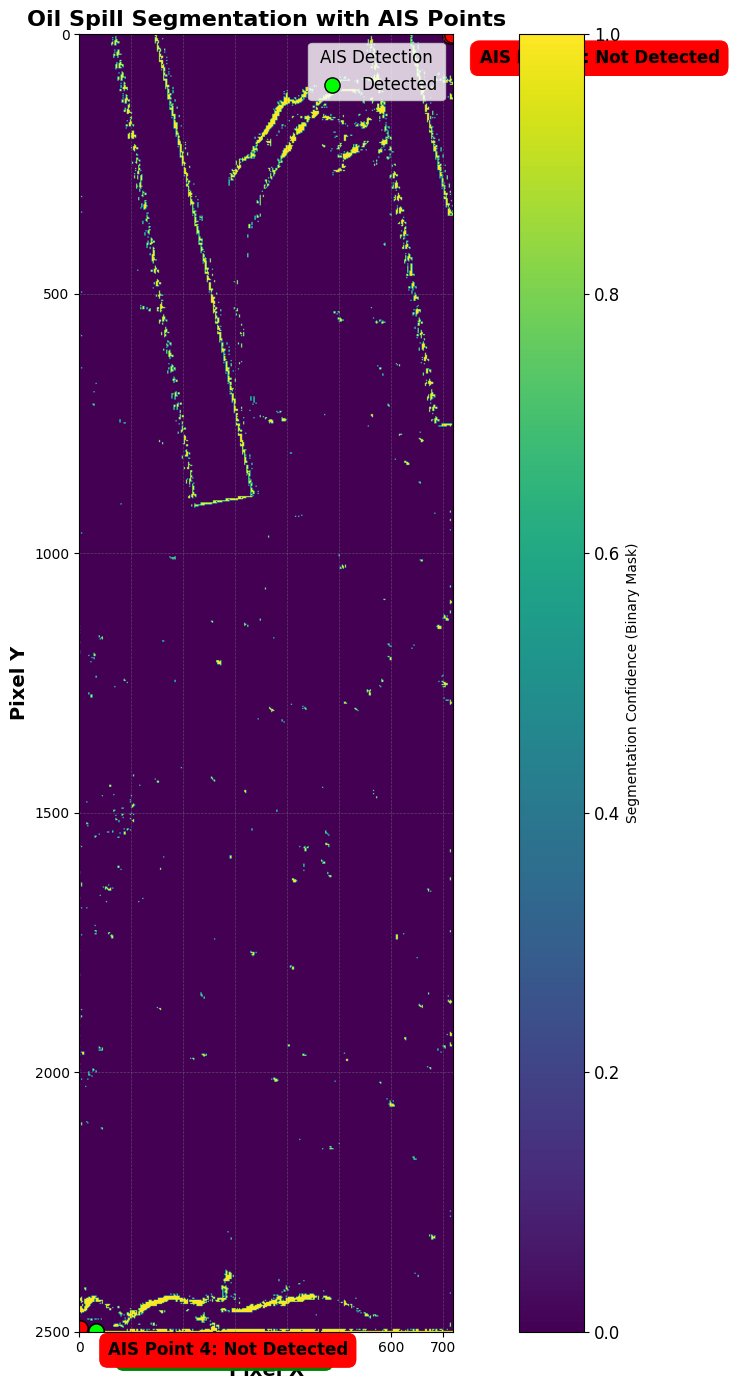

In [99]:
# Enhanced Visualization for Oil Spill Segmentation with Better AIS Point Visibility
plt.figure(figsize=(14, 14))
plt.imshow(binary_mask, cmap='viridis', extent=[0, binary_mask.shape[1], binary_mask.shape[0], 0])
plt.title("Oil Spill Segmentation with AIS Points", fontsize=16, weight='bold')

# Ploting AIS points with readable labels and larger markers
for idx, ((x, y), result) in enumerate(validation_results):
    if 0 <= x < binary_mask.shape[1] and 0 <= y < binary_mask.shape[0]:
        label = f"AIS Point {idx + 1}: {'Detected' if result else 'Not Detected'}"
        plt.annotate(
            label,
            (x, y),
            textcoords="offset points",
            xytext=(20, -20),  # Offset label further away from the marker
            fontsize=12,
            weight='bold',
            color='white' if result else 'black',  # Contrast text color
            bbox=dict(facecolor='green' if result else 'red', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'),
        )
        plt.scatter(
            x, y,
            color='lime' if result else 'red',
            edgecolor='black',
            linewidth=1.0,
            s=120,  # Increase marker size
            label=f'{"Detected" if result else "Not Detected"}' if idx == 0 else None,
            alpha=1.0,
        )

# Adding a color bar
colorbar = plt.colorbar(label="Segmentation Confidence (Binary Mask)")
colorbar.ax.tick_params(labelsize=12)

# Adding labels for axes
plt.xlabel("Pixel X", fontsize=14, weight='bold')
plt.ylabel("Pixel Y", fontsize=14, weight='bold')

# Adding a legend for AIS point types
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12, title="AIS Detection", title_fontsize=12)

# Improving grid visibility
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjusting layout
plt.tight_layout()
plt.show()


# Evaluation Metrics

In [89]:
# Ground Truth and Predicted Labels
# Flattening the binary_mask and validation results to create ground truth and predicted labels
ais_truth = [1 if result else 0 for _, result in validation_results]  # 1 for oil spill detected, 0 otherwise
ais_predictions = [binary_mask[y, x] for (x, y), _ in validation_results]  # Predicted probabilities from the segmentation map

# Threshold the predictions to binary values
ais_pred_binary = [1 if p > 0.5 else 0 for p in ais_predictions]

# Calculate Evaluation Metrics
precision = precision_score(ais_truth, ais_pred_binary)
recall = recall_score(ais_truth, ais_pred_binary)
f1 = f1_score(ais_truth, ais_pred_binary)

print("Evaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(ais_truth, ais_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

Evaluation Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[6 0]
 [0 2]]


IoU (Intersection over Union): 1.0000


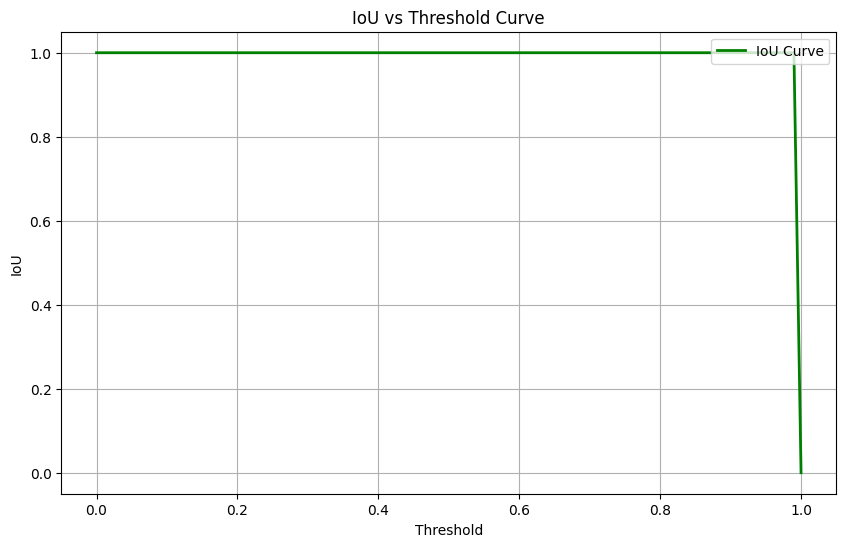

In [90]:
# IoU Calculation
# IoU = Intersection / Union for binary prediction and truth
intersection = sum([(1 if t == 1 and p == 1 else 0) for t, p in zip(ais_truth, ais_pred_binary)])
union = sum([(1 if t == 1 or p == 1 else 0) for t, p in zip(ais_truth, ais_pred_binary)])
iou = intersection / union if union > 0 else 0

print(f"IoU (Intersection over Union): {iou:.4f}")

# IoU Curve (Threshold Variation)
thresholds = np.linspace(0, 1, 100)
iou_values = []
for thresh in thresholds:
    pred_binary = [1 if p > thresh else 0 for p in ais_predictions]
    intersection = sum([(1 if t == 1 and p == 1 else 0) for t, p in zip(ais_truth, pred_binary)])
    union = sum([(1 if t == 1 or p == 1 else 0) for t, p in zip(ais_truth, pred_binary)])
    iou_values.append(intersection / union if union > 0 else 0)

# Ploting IoU Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, iou_values, color='green', lw=2, label='IoU Curve')
plt.title('IoU vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('IoU')
plt.legend(loc='upper right')
plt.grid()
plt.show()


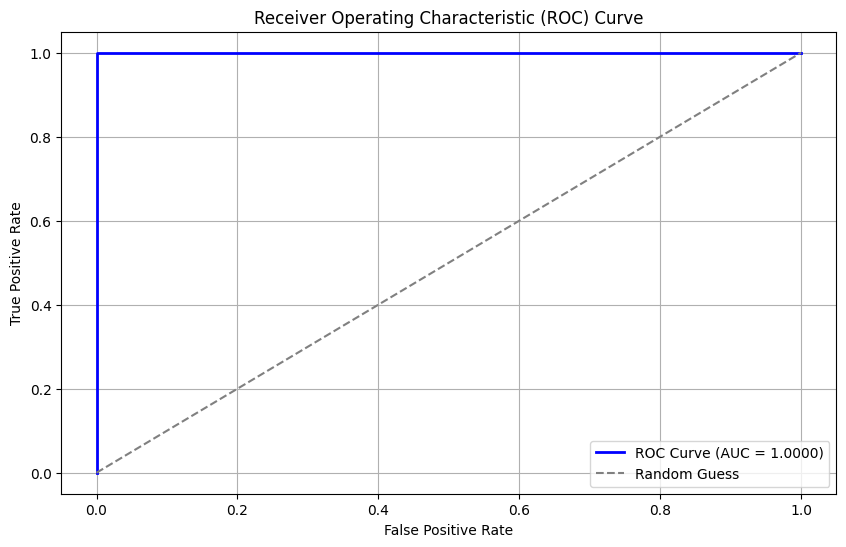

In [91]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(ais_truth, ais_predictions)
roc_auc = auc(fpr, tpr)

# Ploting ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Satellite Data Quality Metrics

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Signal-to-Noise Ratio (SNR): nan
Data Mask Completeness: 23065.39%
Mean Squared Error (VV vs VH): 100.7922
VV Mean: 27.0087, VV Std: 13.9850
VH Mean: 6.4298, VH Std: 4.0139


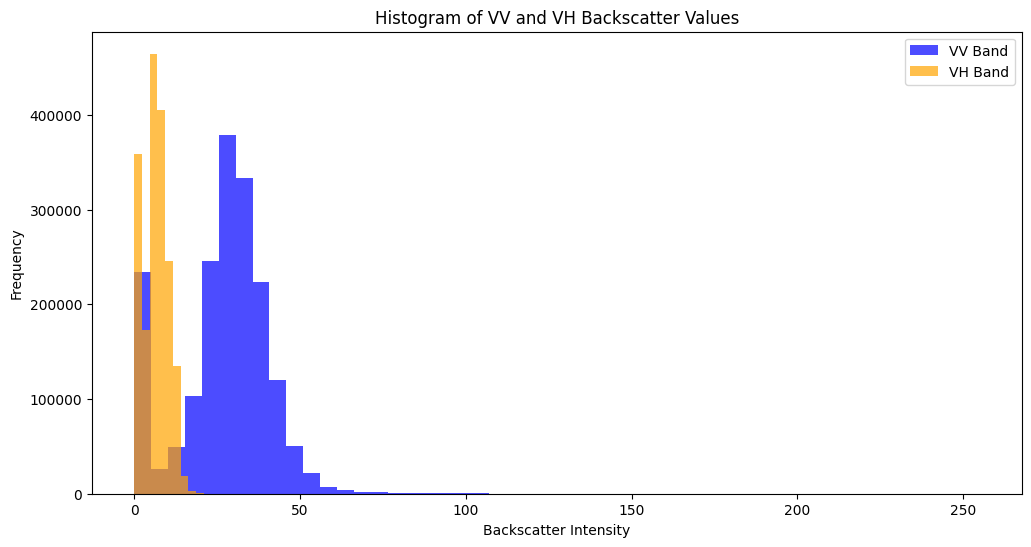

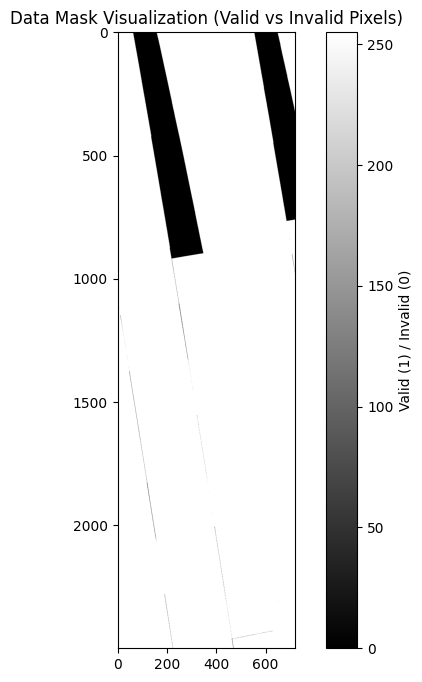

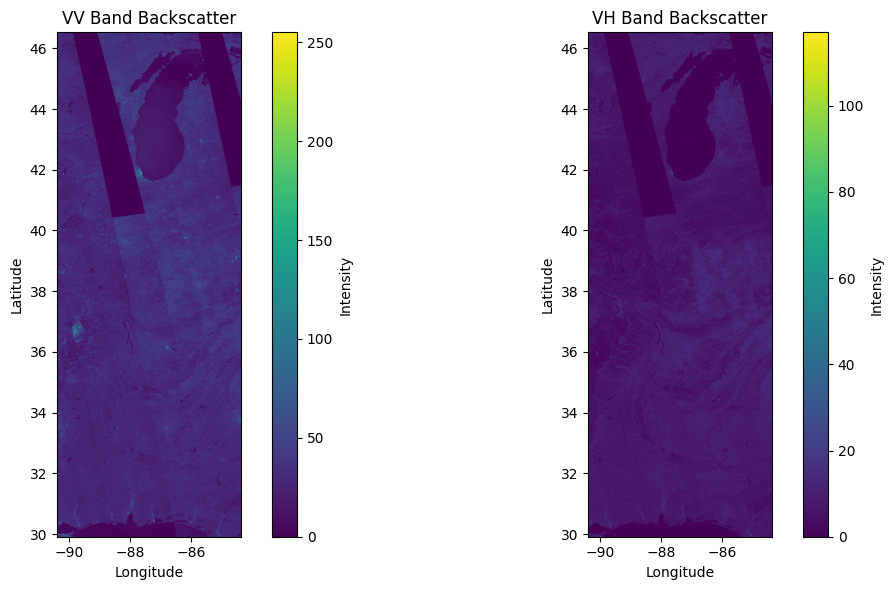

In [92]:
# Extracting satellite bands and the valid data mask
vv_band = satellite_data[:, :, 0]  # VV polarization band
vh_band = satellite_data[:, :, 1]  # VH polarization band
data_mask = satellite_data[:, :, 2]  # Valid data mask (0 or 1)

# Signal-to-Noise Ratio (SNR)
signal_mean = np.mean(vv_band[data_mask == 1])  # Mean signal in valid regions
noise_std = np.std(vv_band[data_mask == 0])  # Noise from invalid regions
snr = signal_mean / noise_std
print(f"Signal-to-Noise Ratio (SNR): {snr:.2f}")

# Data Mask Completeness
valid_pixel_count = np.sum(data_mask)  # Count of valid pixels
total_pixel_count = data_mask.size  # Total number of pixels
completeness = (valid_pixel_count / total_pixel_count) * 100
print(f"Data Mask Completeness: {completeness:.2f}%")

# **3. MSE Between VV and VH Bands**
mse_vv_vh = np.mean((vv_band - vh_band) ** 2)
print(f"Mean Squared Error (VV vs VH): {mse_vv_vh:.4f}")

# Backscatter Intensity Statistics
vv_mean = np.mean(vv_band)
vv_std = np.std(vv_band)
vh_mean = np.mean(vh_band)
vh_std = np.std(vh_band)
print(f"VV Mean: {vv_mean:.4f}, VV Std: {vv_std:.4f}")
print(f"VH Mean: {vh_mean:.4f}, VH Std: {vh_std:.4f}")

# Histogram of Backscatter Values (VV and VH)
plt.figure(figsize=(12, 6))
plt.hist(vv_band.flatten(), bins=50, alpha=0.7, label='VV Band', color='blue')
plt.hist(vh_band.flatten(), bins=50, alpha=0.7, label='VH Band', color='orange')
plt.title('Histogram of VV and VH Backscatter Values')
plt.xlabel('Backscatter Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Quality Visualization: Data Mask
plt.figure(figsize=(8, 8))
plt.imshow(data_mask, cmap='gray')
plt.title("Data Mask Visualization (Valid vs Invalid Pixels)")
plt.colorbar(label='Valid (1) / Invalid (0)')
plt.show()

# Visualize VV and VH Bands
plt.figure(figsize=(12, 6))

# VV Band
plt.subplot(1, 2, 1)
plt.imshow(vv_band, cmap='viridis', extent=[bbox.min_x, bbox.max_x, bbox.min_y, bbox.max_y])
plt.title("VV Band Backscatter")
plt.colorbar(label='Intensity')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# VH Band
plt.subplot(1, 2, 2)
plt.imshow(vh_band, cmap='viridis', extent=[bbox.min_x, bbox.max_x, bbox.min_y, bbox.max_y])
plt.title("VH Band Backscatter")
plt.colorbar(label='Intensity')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


Segmentation Model Evaluation

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC: 1.0000


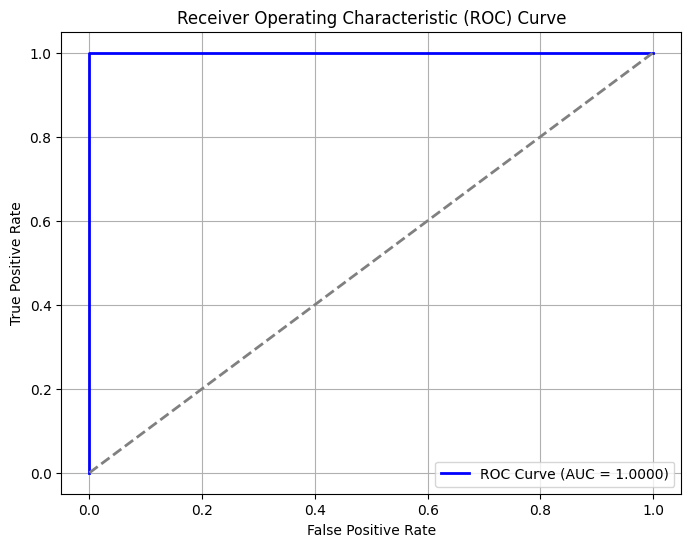

IoU: 1.0000

Confusion Matrix:
True Positive (TP): 2
False Positive (FP): 0
True Negative (TN): 6
False Negative (FN): 0


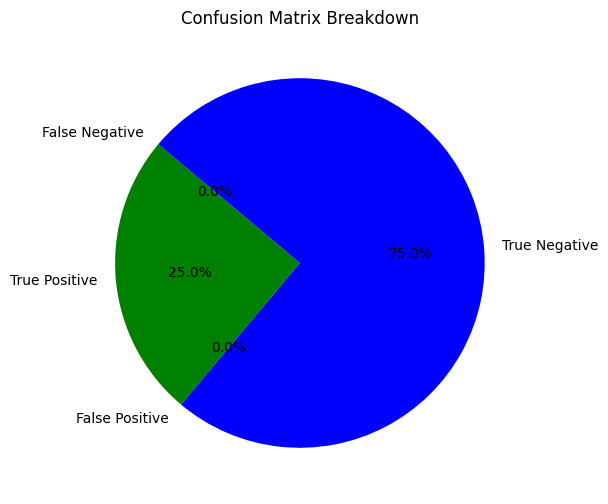

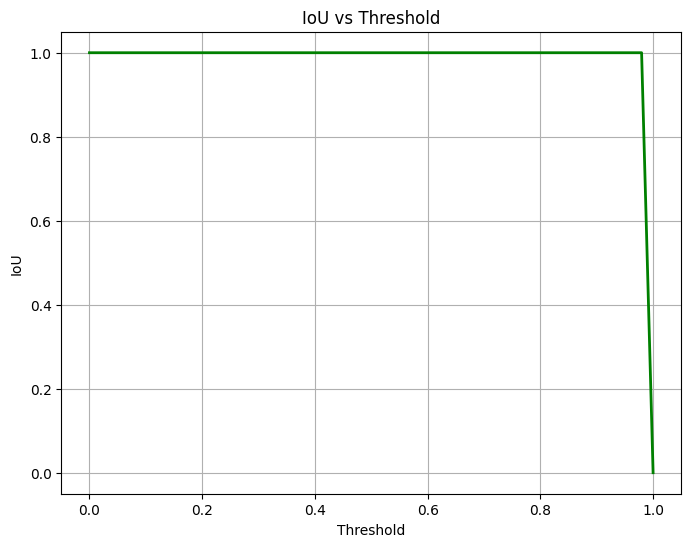

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Precision, Recall, and F1-Score
# Threshold AIS predictions to binary (0 or 1) for precision/recall/F1
ais_predictions_binary = [1 if pred > 0.5 else 0 for pred in ais_predictions]

precision = precision_score(ais_truth, ais_predictions_binary)
recall = recall_score(ais_truth, ais_predictions_binary)
f1 = f1_score(ais_truth, ais_predictions_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(ais_truth, ais_predictions)
roc_auc = roc_auc_score(ais_truth, ais_predictions)

print(f"AUC: {roc_auc:.4f}")

# Ploting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# IoU (Intersection over Union)
# Calculating IoU between AIS truth and predicted labels
intersection = sum((truth == 1 and pred > 0.5) for truth, pred in zip(ais_truth, ais_predictions))
union = sum((truth == 1 or pred > 0.5) for truth, pred in zip(ais_truth, ais_predictions))
iou = intersection / union if union > 0 else 0

print(f"IoU: {iou:.4f}")

# Confusion Matrix
cm = confusion_matrix(ais_truth, ais_predictions_binary)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"True Negative (TN): {tn}")
print(f"False Negative (FN): {fn}")

# Visualizing Confusion Matrix as a Pie Chart
confusion_counts = [tp, fp, tn, fn]
labels = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
colors = ['green', 'red', 'blue', 'orange']

plt.figure(figsize=(6, 6))
plt.pie(confusion_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Confusion Matrix Breakdown")
plt.show()

# IoU Curve Over Thresholds
thresholds = np.linspace(0, 1, 50)
ious = []

for thresh in thresholds:
    predictions_binary = [1 if pred > thresh else 0 for pred in ais_predictions]
    intersection = sum((truth == 1 and pred == 1) for truth, pred in zip(ais_truth, predictions_binary))
    union = sum((truth == 1 or pred == 1) for truth, pred in zip(ais_truth, predictions_binary))
    iou = intersection / union if union > 0 else 0
    ious.append(iou)

# Ploting IoU Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, ious, color='green', lw=2)
plt.title('IoU vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('IoU')
plt.grid()
plt.show()


AIS Points Metrics

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    No Spill       1.00      1.00      1.00         6
       Spill       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


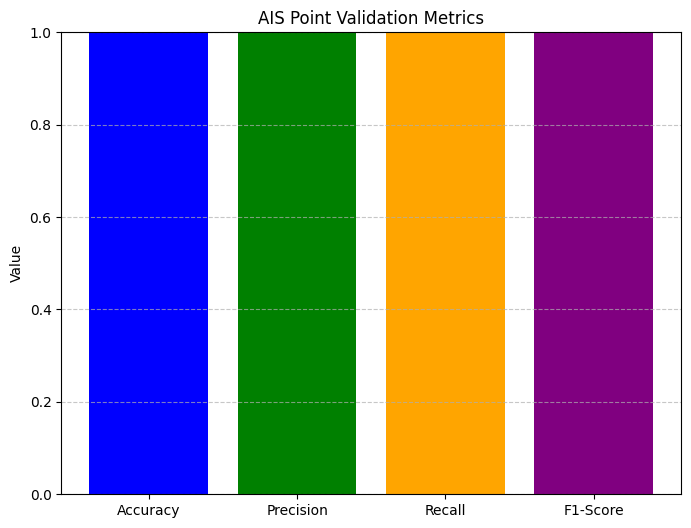

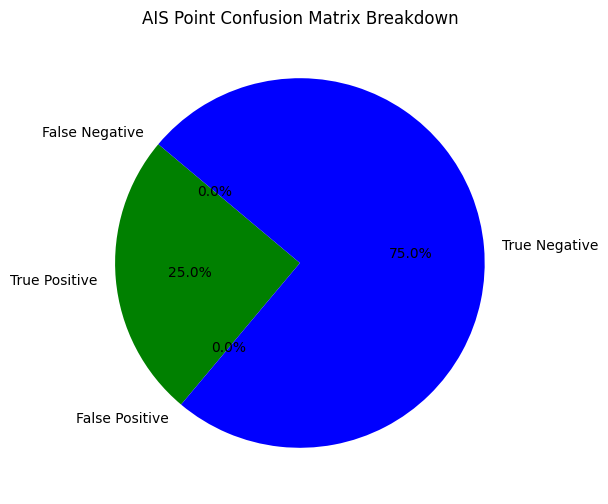

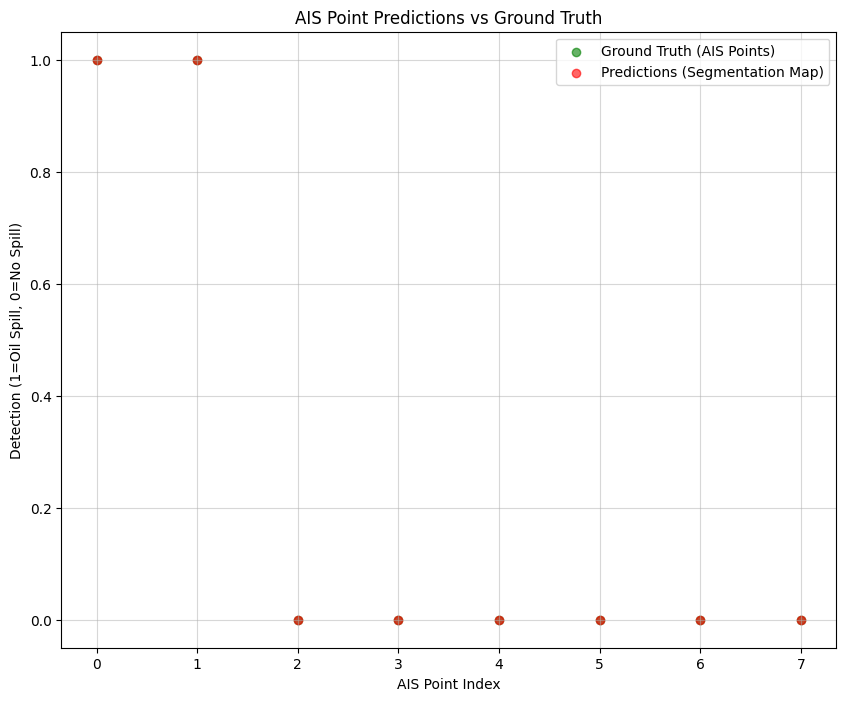

In [96]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
accuracy = accuracy_score(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions])
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions], target_names=['No Spill', 'Spill'])
print("\nClassification Report:")
print(report)

# Precision and Recall for AIS Points
precision = precision_score(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions])
recall = recall_score(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions])
f1 = f1_score(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualizing AIS Point Validation
# Bar plot of validation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title("AIS Point Validation Metrics")
plt.ylabel("Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Confusion Matrix for AIS Points
cm = confusion_matrix(ais_truth, [1 if pred > 0.5 else 0 for pred in ais_predictions])
tn, fp, fn, tp = cm.ravel()

# Visualizing Confusion Matrix as a Pie Chart
confusion_counts = [tp, fp, tn, fn]
labels = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
colors = ['green', 'red', 'blue', 'orange']

plt.figure(figsize=(6, 6))
plt.pie(confusion_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("AIS Point Confusion Matrix Breakdown")
plt.show()

# Scatter Plot of AIS Point Predictions
plt.figure(figsize=(10, 8))
plt.scatter(range(len(ais_truth)), ais_truth, label='Ground Truth (AIS Points)', color='green', alpha=0.6)
plt.scatter(range(len(ais_predictions)), ais_predictions, label='Predictions (Segmentation Map)', color='red', alpha=0.6)
plt.title('AIS Point Predictions vs Ground Truth')
plt.xlabel('AIS Point Index')
plt.ylabel('Detection (1=Oil Spill, 0=No Spill)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()
